# Barclays WSL - xG Differential

We explore xG differentials for the first five rounds of EFL league one fixtures.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib import colormaps
from highlight_text import fig_text

from PIL import Image
import urllib
import os
import math

from highlight_text import fig_text
from bs4 import BeautifulSoup
import requests
from io import StringIO

## Reading the data

We want to group the data by team, regardless if the side played at home or on the road. 

In [3]:
df = pd.read_csv('../data/xgd-1.csv')

In [4]:
df.head(10)

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1,Fri,20/9/2024,19:00 (20:00),Chelsea,1.1,1–0,0.9,Aston Villa,"4,337",Cherry Red Records Fans' Stadium,Kirsty Dowle,Match Report,NaN
1,1,Sat,21/9/2024,12:00 (13:00),Manchester Utd,1.2,3–0,0.9,West Ham,"8,761",Old Trafford,Cheryl Foster,Match Report,NaN
2,1,Sat,21/9/2024,12:30 (13:30),Brighton,2.1,4–0,0.5,Everton,"2,125",Broadfield Stadium,Lauren Impey,Match Report,NaN
3,1,Sun,22/9/2024,12:30 (13:30),Arsenal,2.2,2–2,1.4,Manchester City,"41,818",Emirates Stadium,Abigail Byrne,Match Report,NaN
4,1,Sun,22/9/2024,14:00 (15:00),Tottenham,4.1,4–0,0.3,Crystal Palace,"1,778",Brisbane Road,Amy Fearn,Match Report,NaN
5,1,Sun,22/9/2024,14:00 (15:00),Liverpool,1.4,1–1,0.2,Leicester City,"3,058",Totally Wicked Stadium,Adewunmi Soneye,Match Report,NaN
6,2,Fri,27/9/2024,19:30 (20:30),Crystal Palace,0.3,0–7,2.8,Chelsea,"5,003",Selhurst Park,Emily Heaslip,Match Report,NaN
7,2,Sun,29/9/2024,12:30 (13:30),Manchester City,3.0,1–0,0.8,Brighton,"3,727",Joie Stadium,Stacey Pearson,Match Report,NaN
8,2,Sun,29/9/2024,14:00 (15:00),Everton,0.7,0–1,1.1,Manchester Utd,"1,343",Walton Hall Park,Kirsty Dowle,Match Report,NaN
9,2,Sun,29/9/2024,15:00 (16:00),West Ham,0.7,1–1,1.5,Liverpool,"1,799",Chigwell Construction Stadium,Abigail Byrne,Match Report,NaN


In [5]:
df = df.dropna(subset=['xG'])

In [6]:
df['home_team_score'] = df['Score'].apply(lambda x: int(x[0].split('-')[0]))
df['away_team_score'] = df['Score'].apply(lambda x: int(x[2].split('-')[0]))

In [7]:
df = df.drop(columns=["Notes", "Match Report","Wk","Day","Date","Time","Attendance","Venue","Referee", "Score"])

In [8]:
df.columns = ['home_team_name','home_team_xG','away_team_xG','away_team_name','home_team_score', 'away_team_score']

In [12]:
fotmob = pd.read_csv('../data/fotmob_fbref.csv')

In [13]:
df = pd.merge(left=df, right=fotmob, left_on='home_team_name', right_on='name', how='left')
df = df.rename(columns={'fotmob_id': 'home_team_id'})
df = df.drop('name', axis=1)
df = pd.merge(left=df, right=fotmob, left_on='away_team_name', right_on='name', how='left')
df = df.rename(columns={'fotmob_id': 'away_team_id'})
df = df.drop('name', axis=1)
df.head(100)

,home_team_name,home_team_xG,away_team_xG,away_team_name,home_team_score,away_team_score,home_team_id,away_team_id
0,Chelsea,1.1,0.9,Aston Villa,1,0,258661,231494
1,Manchester Utd,1.2,0.9,West Ham,3,0,954396,231497
2,Brighton,2.1,0.5,Everton,4,0,231505,258663
3,Arsenal,2.2,1.4,Manchester City,2,2,258657,231488
4,Tottenham,4.1,0.3,Crystal Palace,4,0,628117,614828
...,...,...,...,...,...,...,...,...
95,Tottenham,0.2,1.5,Brighton,0,1,628117,231505
96,Everton,1.4,1.1,Crystal Palace,3,0,258663,614828
97,Arsenal,1.5,0.1,Liverpool,4,0,258657,258665
98,West Ham,2.0,1.7,Tottenham,2,0,231497,628117


In [14]:
df_h = (
    df[['home_team_' + x for x in ['name', 'id', 'score', 'xG']]]
    .rename(
        columns={
            'home_team_name':'team_name',
            'home_team_id':'team_id',
            'home_team_score':'score',
            'home_team_xG':'xG',
        }
    )
)

df_a = (
    df[['away_team_' + x for x in ['name', 'id', 'score', 'xG']]]
    .rename(
        columns={
            'away_team_name':'team_name',
            'away_team_id':'team_id',
            'away_team_score':'score',
            'away_team_xG':'xG',
        }
    )
)

data = pd.concat([df_h, df_a]).reset_index(drop=True)
data = data.groupby(['team_name', 'team_id']).sum().reset_index()
data = data.assign(difference = data['score'] - data['xG'])
data = data.sort_values(by='difference').reset_index(drop=True)
data.head()

,team_name,team_id,score,xG,difference
0,Liverpool,258665,22,25.2,-3.2
1,Crystal Palace,614828,20,20.1,-0.1
2,Tottenham,628117,26,26.1,-0.1
3,Leicester City,614954,21,19.6,1.4
4,Brighton,231505,35,31.9,3.1


In [15]:
gradient = [
    '#de6f57',
    '#d5724d',
    '#cb7644',
    '#c0783e',
    '#b57b38',
    '#a97d35',
    '#9e7f34',
    '#928134',
    '#878137',
    '#7c823a',
    '#71823f',
    '#668244',
    '#5c814a',
    '#528050',
    '#497f56',
    '#407d5b',
    '#387b61',
    '#317966',
    '#2c776a',
    '#29756e',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
# cm.register_cmap(name='SOC', cmap=soc_cm)
colormaps.register(name='SOC', cmap=soc_cm)

ValueError: A colormap named "SOC" is already registered.

## The Visual

First we create a simple horizontal bar chart

In [18]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if (y.split(".")[-1] == "ttf") or (y.split(".")[-1] == "otf"):
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("soc_base.mplstyle")

<BarContainer object of 12 artists>

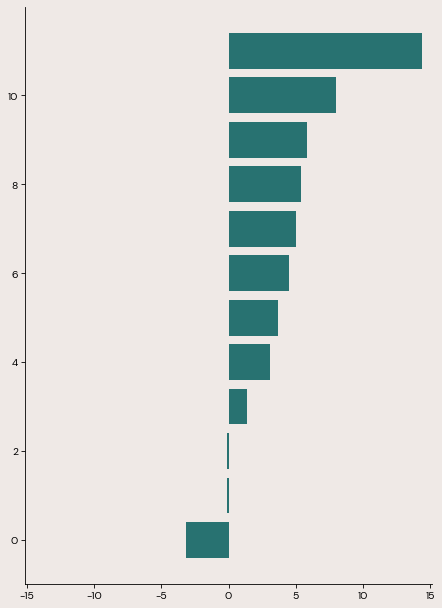

In [19]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()
# Ensure symmetrical limits on the x-axis
max_ = max(abs(data['difference'].min()), data['difference'].max())
# Add 5% margin of that limit to the x-axis
max_ = max_*(1.05)
ax.set_xlim(-max_, max_)

ax.barh(data.index, data['difference'])

In [20]:
def add_logo_on_ax(ax, team_id, bw = True):
    '''
    This function adds the logo of a football team on a specific
    axes based on the Fotmob team ID.
    Args:
        - ax (object): the matplotlib axes object.
        - team_id (int): the Fotmob team ID.
        - bw (bool): whether to add the logo as black & white or with color.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png')).convert('LA')
    if bw:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis("off")
    return ax

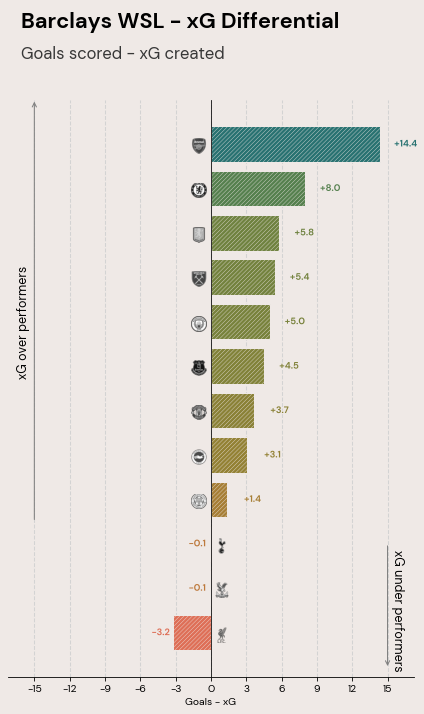

In [21]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()
plt.rcParams['font.family'] = "DM Sans"
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
# -- Hatches --------------------------------------
plt.rcParams['hatch.linewidth'] = 0.35
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(data['difference'].min()), data['difference'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.2)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, data.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.set_xlabel('Goals - xG', size=10)

# -- Bar Chart -------------------------------------
# Declare CMAP & Normalization
norm = mcolors.Normalize(vmin=data['difference'].min(),vmax=data['difference'].max())
cmap = plt.get_cmap('SOC')
ax.barh(
    data.index, data['difference'],
    hatch='//////', ec='#efe9e6',
    color = cmap(norm(data['difference'])),
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)
# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for index, x in enumerate(data['difference']):
    if x < 0:
        sign_offset = -1
        offset_logo = .25
        sign_text = ''
    else:
        sign_offset = 2
        offset_logo = .85
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*12,0),
        text=f'{sign_text}{x:.1f}',
        color= cmap(norm(x)),
        size=9,
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])
    # -- Add the logo
    team_id = data['team_id'].iloc[index]
    ax_coords = DC_to_NFC([sign_offset*(-1)*offset_logo, index - 0.3])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = "C")
    add_logo_on_ax(logo_ax, team_id, True)

# -- Figure title and arrows --------------------------------
position_negative = data[data['difference'] < 0].index.max()
position_x_negative = math.floor(-max_*(.85))
position_x_positive = math.ceil(max_*(.85))
ax.annotate(
    xy=(position_x_negative,position_negative + .5),
    xytext=(position_x_negative,ax.get_ylim()[1]),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
ax.annotate(
    xy=(position_x_positive,position_negative),
    xytext=(position_x_positive,ax.get_ylim()[0] + .2),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
mid_point_positive = (position_negative + ax.get_ylim()[1])/2
mid_point_negative = (position_negative + ax.get_ylim()[0])/2
ax.annotate(
    xy=(position_x_negative,mid_point_positive),
    text='xG over performers',
    rotation=90,
    xytext=(-10,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)
ax.annotate(
    xy=(position_x_positive,mid_point_negative),
    text='xG under performers',
    rotation=-90,
    xytext=(10,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)

fig_text(
    x = 0.15, y = .97, 
    s = 'Barclays WSL - xG Differential',
    va = 'bottom', ha = 'left',
    fontsize = 21, color = 'black', font = 'DM Sans', weight = 'bold'
)

fig_text(
    x = 0.15, y = 0.93, 
    s = 'Goals scored - xG created',
    va = 'bottom', ha = 'left',
    fontsize = 16, color = "#373737"
)

plt.savefig(
	"../figures/wsl_gd.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"../figures/wsl_gd_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)